# Gated Recurrent Units (GRU)

In [1]:
import d2l
from mxnet import np, npx
from mxnet.gluon import rnn
npx.set_np()

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

Initialize model parameters.

In [2]:
def get_params(vocab_size, num_hiddens, ctx):
    num_inputs = num_outputs = vocab_size
    normal = lambda shape : np.random.normal(scale=0.01, size=shape, ctx=ctx)
    three = lambda : (normal((num_inputs, num_hiddens)),
                      normal((num_hiddens, num_hiddens)),
                      np.zeros(num_hiddens, ctx=ctx))
    W_xz, W_hz, b_z = three()  # Update gate parameter
    W_xr, W_hr, b_r = three()  # Reset gate parameter
    W_xh, W_hh, b_h = three()  # Candidate hidden state parameter
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = np.zeros(num_outputs, ctx=ctx)
    # Create gradient
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.attach_grad()
    return params

Initializing the hidden state.

In [3]:
def init_gru_state(batch_size, num_hiddens, ctx):
    return (np.zeros(shape=(batch_size, num_hiddens), ctx=ctx), )

The model.

In [4]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = npx.sigmoid(np.dot(X, W_xz) + np.dot(H, W_hz) + b_z)
        R = npx.sigmoid(np.dot(X, W_xr) + np.dot(H, W_hr) + b_r)
        H_tilda = np.tanh(np.dot(X, W_xh) + np.dot(R * H, W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = np.dot(H, W_hq) + b_q
        outputs.append(Y)
    return np.concatenate(outputs, axis=0), (H,)

Training.

Perplexity 1.1, 7514 tokens/sec on gpu(0)
time traveller for so it will be convenient to speak of him was 
traveller  it s against reason said filby  what reason said


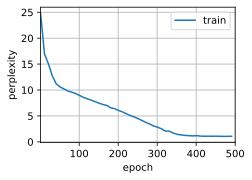

In [5]:
vocab_size, num_hiddens, ctx = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, ctx, get_params,
                            init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, ctx)

Concise Implementation.

Perplexity 1.1, 125154 tokens/sec on gpu(0)
time traveller  it s against reason said filby  what reason said
traveller  it s against reason said filby  what reason said


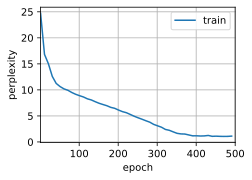

In [6]:
gru_layer = rnn.GRU(num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, ctx)